In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import os

This Notebook uses the event observations made for customers in `create-churn-dataset` to perform cohort analysis for a metric of interest and plot this analysis.

The procedure is as follows:

1. Using the metric and the variable representing churn or non-churn, sort the observations by metric value.
2. Group the observations into cohorts by dividing the observations into equal-sized groups (we default to deciles).
3. For each cohort, calculate:
    - the average value of the metric for all observations in the cohort
    - the percentage of churns in the cohort observations
4. Plot the average metric values and churn rates.

Sometimes, a customer appears more than once in one cohort;
at other times, the same customer appears in different cohorts. This makes sense because we're investigating the hypothesis that the behaviour represented by the metric is related to churn, not that the identity of the customer or the timing of the observation is related to churn. 

In [7]:
def cohort_plot(data_set_path, metric_to_plot, ncohort=10):
    assert os.path.isfile(data_set_path), f"{data_set_path} is not a valid path"
    churn_data = pd.read_csv(data_set_path, index_col=[0, 1])
    # group into cohorts and return a series of the group numbers
    groups = pd.qcut(churn_data[metric_to_plot], ncohort, duplicates='drop')
    # calculate the mean metric value for each cohort
    cohort_means = churn_data.groupby(groups)[metric_to_plot].mean()
    # calculate the churn rate for each cohort
    cohort_churns = churn_data.groupby(groups)['is_churn'].mean()
    # msk a new DataFrame from the cohorts
    plot_frame = pd.DataFrame({
        metric_to_plot: cohort_means.values,
        'churn_rate': cohort_churns
        })
    
    plt.figure(figsize=(6, 4))
    plt.plot(metric_to_plot, 
             'churn_rate',
             data=plot_frame,
             marker='o',
             linewidth=2,
             label=metric_to_plot)
    plt.xlabel('Cohort Average of "%s"' % metric_to_plot)
    plt.ylabel('Cohort Churn Rate (%)')
    plt.grid()
    plt.gca().set_ylim(bottom=0)
    plt.show()
    

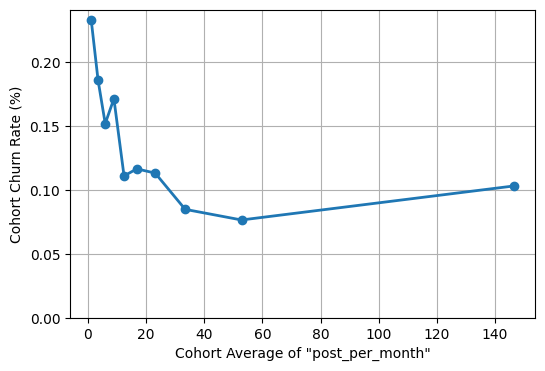

In [8]:
# product a cohort plot for posts per month:
cohort_plot('../create-churn-dataset/socialnet_dataset.csv', 'post_per_month')